<a href="https://colab.research.google.com/github/gagyeomkim/paper-review/blob/main/GoogLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Going deeper with convolutions

***Import Modules***

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from torchsummary import summary

***Data Preparation***

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [ ]:
batch_size=128

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:18<00:00, 9.04MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
classes = ('plane',
           'car',
           'bird',
           'cat',
           'deer',
           'dog',
           'frog',
           'horse',
           'ship',
           'truck')

***Image Test***

In [ ]:
def imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

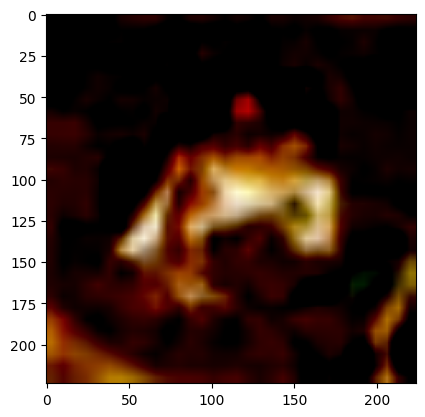

frog


In [ ]:
imshow(train_set[0][0])
print(classes[train_set[0][1]])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

***convolution layer***

In [ ]:
class BaseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BaseConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.conv(x))

***Inception Module 구현***

padding은 추후 4개의 brancb가 합쳐졌을 때의 크기를 고려하여 맞춰줌

(구체적으로는 height와 width는 그대로 유지되도록 패딩을 정함)

In [ ]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3_red, ch3x3, ch5x5_red, ch5x5, pool):
        super(InceptionModule, self).__init__()

        self.conv1x1 = nn.Conv2d(in_channels, ch1x1, kernel_size=1)

        self.conv3x3 = nn.Sequential(
            BaseConv2d(in_channels, ch3x3_red, kernel_size=1),
            BaseConv2d(ch3x3_red, ch3x3, kernel_size=3, padding=1)
        )

        self.conv5x5 = nn.Sequential(
            BaseConv2d(in_channels, ch5x5_red, kernel_size=1),
            BaseConv2d(ch5x5_red, ch5x5, kernel_size=5, padding=2)
        )

        self.pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BaseConv2d(in_channels, pool, kernel_size=1)
        )

    def forward(self, x):
        x1 = self.conv1x1(x)
        x2 = self.conv3x3(x)
        x3 = self.conv5x5(x)
        x4 = self.pool(x)

        return torch.cat([x1, x2, x3, x4], 1)

***Auxiliary Classifier***

In [ ]:
class AuxClassifier(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(AuxClassifier, self).__init__()

        self.avgpool = nn.AdaptiveAvgPool2d((4,4))
        self.conv1 = BaseConv2d(in_channels, 128, kernel_size=1)
        self.fc = nn.Sequential(
            nn.Linear(4*4*128, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.7),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv1(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

***GoogLeNet***

In [ ]:
class GoogLeNet(torch.nn.Module):
    def __init__(self, in_channels, num_classes):
        super(GoogLeNet, self).__init__()

        self.training = True

        self.conv1 = nn.Sequential(
            BaseConv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.LocalResponseNorm(2)
        )

        self.conv2 = nn.Sequential(
            BaseConv2d(64, 64, kernel_size=1),
            BaseConv2d(64, 192, kernel_size=3, padding=1),
            nn.LocalResponseNorm(2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.inception_3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception_3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool_3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception_4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.aux1 = AuxClassifier(512, num_classes)


        self.inception_4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception_4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception_4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.aux2 = AuxClassifier(528, num_classes)

        self.inception_4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.maxpool_4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception_5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception_5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout2d(p=0.4)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.maxpool_3(x)

        x = self.inception_4a(x)
        if self.training:
            out1 = self.aux1(x)

        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        if self.training:
            out2 = self.aux2(x)

        x = self.inception_4e(x)
        x = self.maxpool_4(x)

        x = self.inception_5a(x)
        x = self.inception_5b(x)

        x = self.avgpool(x)

        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        if self.training:
            return [x, out1, out2]
        else:
            return x

    def set_train(self):
        self.training = True

    def set_eval(self):
        self.training = False

In [ ]:
# model = GoogLeNet(3, 10)
model = GoogLeNet(3, 10).cuda()

summary(model, input_size=(3, 224, 224), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
              ReLU-2         [-1, 64, 112, 112]               0
        BaseConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
 LocalResponseNorm-5           [-1, 64, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]           4,160
              ReLU-7           [-1, 64, 56, 56]               0
        BaseConv2d-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 192, 56, 56]         110,784
             ReLU-10          [-1, 192, 56, 56]               0
       BaseConv2d-11          [-1, 192, 56, 56]               0
LocalResponseNorm-12          [-1, 192, 56, 56]               0
        MaxPool2d-13          [-1, 192, 28, 28]               0
           Conv2d-14           [-1, 64,

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


***Train & Validation***

In [ ]:
lr = 1e-4
epochs = 20

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
for epoch in range(epochs):
    print("\nEpoch: ", epoch)

    # train
    print("\nTrain: ")
    model.train()
    model.set_train()
    train_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        pred0, pred1, pred2 = model(images)
        loss0 = F.cross_entropy(pred0, labels)
        loss1 = F.cross_entropy(pred1, labels)  # auxiliary classifier 1의 loss
        loss2 = F.cross_entropy(pred2, labels)  # auxiliary classifier 2의 loss

        loss = loss0 + 0.3 * loss1 + 0.3 * loss2    # 논문대로 0.3의 손실 비율만 반영
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if ((i+1) % (len(train_loader) // 30) == 1 or i+1 == len(train_loader)):
            print('[%3d/%3d] | Loss: %.5f'%(i+1, len(train_loader), train_loss/(i+1)))

    # val
    print("\nValidation")
    model.eval()
    model.set_eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)

            out = model(images)
            loss = F.cross_entropy(out, labels)

            val_loss += loss.item()
            pred = torch.argmax(out, 1)
            correct += (pred==labels).sum().item()

            if ((i+1) % (len(test_loader) // 3) == 1) or i+1 == len(test_loader):
                print('[%3d/%3d] | Loss: %.5f'%(i+1, len(test_loader), val_loss/(i+1)))

        print(f"Accuracy of the network : {100*correct//(len(test_loader)*batch_size)}%")


Epoch:  0

Train: 
[  1/391] | Loss: 3.68565
[ 14/391] | Loss: 3.68470
[ 27/391] | Loss: 3.68442
[ 40/391] | Loss: 3.68483
[ 53/391] | Loss: 3.68425
[ 66/391] | Loss: 3.68032
[ 79/391] | Loss: 3.66940
[ 92/391] | Loss: 3.64741
[105/391] | Loss: 3.61670
[118/391] | Loss: 3.59014
[131/391] | Loss: 3.56489
[144/391] | Loss: 3.54158
[157/391] | Loss: 3.52068
[170/391] | Loss: 3.50153
[183/391] | Loss: 3.48115
[196/391] | Loss: 3.46044
[209/391] | Loss: 3.43696
[222/391] | Loss: 3.42102
[235/391] | Loss: 3.40563
[248/391] | Loss: 3.38814
[261/391] | Loss: 3.37025
[274/391] | Loss: 3.35406
[287/391] | Loss: 3.33964
[300/391] | Loss: 3.32438
[313/391] | Loss: 3.30883
[326/391] | Loss: 3.29442
[339/391] | Loss: 3.27720
[352/391] | Loss: 3.26269
[365/391] | Loss: 3.24702
[378/391] | Loss: 3.23004
[391/391] | Loss: 3.21584

Validation
[  1/ 79] | Loss: 1.70974
[ 27/ 79] | Loss: 1.77100
[ 53/ 79] | Loss: 1.76844
[ 79/ 79] | Loss: 1.76339
Accuracy of the network : 35%

Epoch:  1

Train: 
[  1/391